# Titanic Dataset EDA and Prediction Models

## The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Using the patterns we find in the train.csv data, we are predicting whether the other 418 passengers on board (found in test.csv) survived.

## Importing required python libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import RidgeClassifier,RidgeClassifierCV
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Importing test and train data

In [2]:
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv",index_col=[0])
test = pd.read_csv("../input/titanic/test.csv",index_col=[0])
train = pd.read_csv("../input/titanic/train.csv",index_col=[0])

## A few utilities function

In [3]:
def initializeFeatureAndTargetFrame(completeData):
    X = (completeData.copy())[['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
    y = (completeData.copy())['Survived']
    return X,y

def write_prediction(model,description=""):
    SubmissionFileName = 'submission_'+datetime.now().strftime('%Y%m%d%H%M%S')+'.csv'
    y_pred = model.predict(test)
    df_y_pred = pd.DataFrame(y_pred, index=test.index, columns=['Survived'])
    df_y_pred.to_csv(SubmissionFileName)
    return SubmissionFileName

## Visualizing NULL data

Text(0.5, 1.0, 'Null values heatmap')

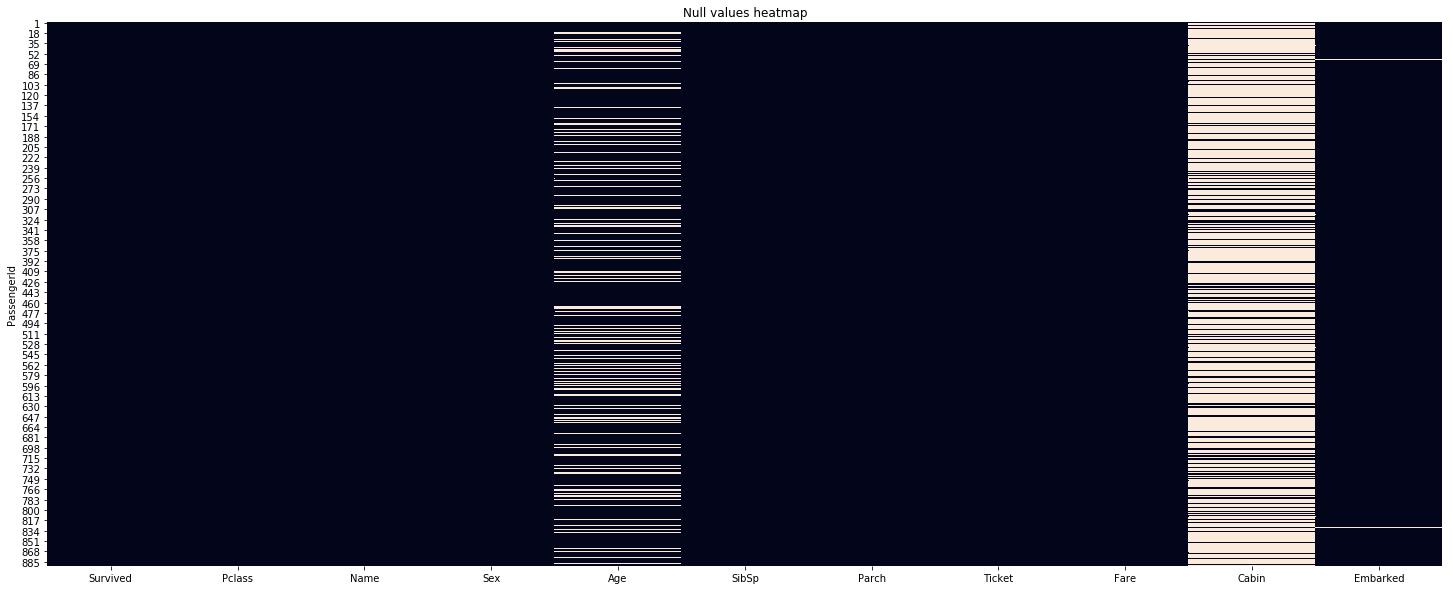

In [4]:
plt.subplots(figsize=(25,10))
sns.heatmap(train.isnull(), cbar=False).set_title("Null values heatmap")

## Visualizing feature correlation

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


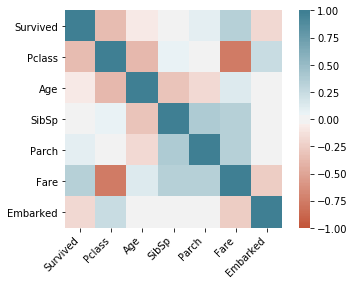

In [6]:
OrdEncoder = OrdinalEncoder()
train_transf = OrdEncoder.fit_transform((train.dropna(subset=['Embarked','Age']))[['Survived','Pclass','Age', 'SibSp','Parch','Fare','Embarked']])
df_train_transf = pd.DataFrame(train_transf, columns=['Survived','Pclass','Age', 'SibSp','Parch','Fare','Embarked'])
feat_corr = df_train_transf.corr()

ax = sns.heatmap(
    feat_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

* There is perfect negative correlation between Fare and Pclass
* There is strong negative correlation between Age and Pclass
* There is positive correlation between Fare and SibSp, Fare and Parch, Fare and Survived
* There is relatively stronger positive correlation between Parch and SibSp

## Concatenating train and test data without submission column

In [7]:
data = np.concatenate([train[['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked']],test],axis=0)

## Prediction model using numeric columns only

In [8]:
X,y = initializeFeatureAndTargetFrame(train)

In [9]:
num_cols = X.select_dtypes(include='number').columns.values
NumRidgeModel = Pipeline([
    ('cs', ColumnTransformer([
        ('num_cols', SimpleImputer(missing_values=np.NaN), num_cols)
    ])),
    ('Predictor', RidgeClassifier())
])
#NumRidgeModel.fit(X,y)
#write_prediction(NumRidgeModel)

## Prediction model after imputing values

**Changes to train data**
* Age : Imputing with Median value
* Embarked : Imputing with most_frequent and Encoding using OneHotEncoder
* Sex,Parch,Pclass,SibSp : Encoding using OneHotEncoder
* Fare : Imputing with mean values

In [10]:
ImputEncodeFeature = Pipeline([
    ('si',SimpleImputer(strategy='most_frequent', missing_values=np.NaN)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
NumCatRidgeModel =Pipeline([
    ('cs', ColumnTransformer(transformers=[
        ('age_transformer', SimpleImputer(strategy='median', missing_values=np.NaN), ['Age']),
        ('Embarked_transformer',ImputEncodeFeature, ['Embarked']),
        ('sex_encoder', OneHotEncoder(handle_unknown='ignore'), ['Sex','Parch','Pclass','SibSp']),
        ('rem_feature', SimpleImputer(strategy='mean', missing_values=np.NaN), ['Fare']),
    ],remainder='drop')),
    ('predictor', RidgeClassifier())
])
#NumCatRidgeModel.fit(X,y)
#write_prediction(NumCatRidgeModel)
#Score : 0.76555

## Model with Polynomial features and Iterative Imputer
**Changes to train data**
* Age,Fare : Iterative Imputing using ExtraForestRegressor
* Embarked,Parch,Pclass,SibSp : Imputing with most_frequent and Encoding using OneHotEncoder

In [11]:
NumCatIIRidgeModel =Pipeline([
    ('cs_ii', ColumnTransformer(transformers=[
        ('featureExtracter', 'passthrough', ['Sex']),
        ('si', SimpleImputer(strategy='most_frequent'),['Embarked']),
        ('ii', IterativeImputer(random_state=42, estimator=ExtraTreesRegressor(), ), ['Pclass','SibSp','Parch','Age','Fare'])
    ])),
    ('cs', ColumnTransformer(transformers=[
        ('featureExtracter', 'passthrough', [5,6]),
        ('sex_encoder', OneHotEncoder(handle_unknown='ignore'), [0,1,2,3,4])
    ])),
    ('pf', PolynomialFeatures(2)),
    ('svd', TruncatedSVD(n_components=15)),
    ('predictor', RidgeClassifier())
])
#NumCatIIRidgeModel.fit(X,y)
#write_prediction(NumCatIIRidgeModel)
#Score : 0.78947
#Rank : 3571

## Model with Polynomial features, Iterative Imputer and Hashing Vectorizer
**Changes to train data**
* Age,Fare : Iterative Imputing using ExtraForestRegressor
* Embarked,Parch,Pclass,SibSp : Imputing with most_frequent and Encoding using OneHotEncoder
* Added Text feature __Name__ using Hashing Vectorizer

In [12]:
class nameExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.reshape(len(X),)
    
name_feature_pipe = Pipeline([
    ('ne', nameExtractor()),
    ('cv', HashingVectorizer(n_features=3000))
])
        
NumCatTextRidgeModel =Pipeline([
    ('cs_ii', ColumnTransformer(transformers=[
        ('featureExtracter', 'passthrough', ['Sex','Name']),
        ('si', SimpleImputer(strategy='most_frequent'),['Embarked']),
        ('ii', IterativeImputer(random_state=42, estimator=ExtraTreesRegressor()), ['Pclass','SibSp','Parch','Age','Fare'])
    ])),
    ('cs', ColumnTransformer(transformers=[
        ('ohe_sex', OneHotEncoder(handle_unknown='ignore'), [0]),
        ('nfp', name_feature_pipe, [1]),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), [2,3,4,5]),
        ('featureExtracter', 'passthrough', [6,7])
    ])),
    ('svd', TruncatedSVD(n_components=3000)),
    ('predictor', RidgeClassifier())
])
#NumCatTextRidgeModel.fit(X,y);
#write_prediction(NumCatTextRidgeModel)
#Score : 0.79904
#Rank : 1728

## Next Steps:
* prediction model using just the Name column
* Hyperparameter tuning of Name Predictor model
* Hyperparameter tuning of the complete model

In [13]:
class nameExtractor2(BaseEstimator, TransformerMixin):
    def __init__(self,column):
        self.column = column
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return [col for col in X[self.column]]
        #return X_feat

In [14]:
name_predictor_model = Pipeline([
    ('ne', nameExtractor2('Name')),
    ('cv', HashingVectorizer(n_features=3000)),
    ('predictor', RidgeClassifier())
])

#name_predictor_model.fit(X,y)
#write_prediction(name_predictor_model)
#Score: 0.80861
#Score with 3000 features: 0.80861
#Rank: 845

### This model shoes that there is a highly positive correlation between Survived and Name feature
#### Next Step
* We will hypertune name_predictor_model using GridSearchCV for a better score

In [15]:
name_predictor_model = Pipeline([
    ('ne', nameExtractor2('Name')),
    ('cv', HashingVectorizer()),
    ('predictor', RidgeClassifier())
])
grid = {'cv__n_features':range(1000,100001,1000),'cv__stop_words':['english','None'],
        'cv__norm':['l1','l2'],'cv__ngram_range':[(1,1),(1,2)],'predictor__alpha':np.logspace(-3,3,10)}
name_predictor_modelGS = Pipeline([
    ('gs',GridSearchCV(estimator=name_predictor_model,param_grid=grid, scoring='average_precision', cv=3, n_jobs=-1))
])
#name_predictor_modelGS.fit(X,y);
#write_prediction(name_predictor_modelGS)

grid = {'cv__n_features': 4000, 'cv__ngram_range': (1, 1), 'cv__norm': 'l1', 'cv__stop_words': 'english', 'predictor__alpha': 2.154434690031882}
score: 0.794,
scorer: default
    
grid = {'cv__n_features': 4000, 'cv__ngram_range': (1, 1), 'cv__norm': 'l1', 'cv__stop_words': 'english',
'predictor__alpha': 2.154434690031882}
score: 0.765,
scorer: recall

grid = {'cv__n_features': 62000, 'cv__ngram_range': (1, 2), 'cv__norm': 'l2', 'cv__stop_words': 'english',
 'predictor__alpha': 0.46415888336127775}
score: 0.79425,
scorer: f1

grid = {'cv__n_features': 87000, 'cv__ngram_range': (1, 2), 'cv__norm': 'l2', 'cv__stop_words': 'english',
 'predictor__alpha': 0.46415888336127775}
score: 0.78947,
scorer: average_precision


In [16]:
tfidf_name_predictor_model = Pipeline([
    ('ne', nameExtractor2('Name')),
    ('tfidf', TfidfVectorizer()),
    ('predictor', RidgeClassifier())
])
grid = {'tfidf__max_df': (0.25, 0.5, 0.75),'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'predictor__alpha':np.logspace(-3,3,10)}
tfidf_name_predictor_modelGS = Pipeline([
    ('gs',GridSearchCV(estimator=tfidf_name_predictor_model,param_grid=grid, scoring='average_precision', cv=3, n_jobs=-1))
])
#tfidf_name_predictor_modelGS.fit(X,y);
#write_prediction(tfidf_name_predictor_modelGS)
#Score: 0.79425

## Hypertuning Current best : NumCatTextRidgeModel model

In [17]:
class nameExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.reshape(len(X),)
    
name_feature_pipe = Pipeline([
    ('ne', nameExtractor()),
    ('cv', HashingVectorizer(n_features=3000))
])
        
RidgeCV_NumCatTextRidgeModel =Pipeline([
    ('cs_ii', ColumnTransformer(transformers=[
        ('featureExtracter', 'passthrough', ['Sex','Name']),
        ('si', SimpleImputer(strategy='most_frequent'),['Embarked']),
        ('ii', IterativeImputer(random_state=42, estimator=ExtraTreesRegressor()), ['Pclass','SibSp','Parch','Age','Fare'])
    ])),
    ('cs', ColumnTransformer(transformers=[
        ('ohe_sex', OneHotEncoder(handle_unknown='ignore'), [0]),
        ('nfp', name_feature_pipe, [1]),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), [2,3,4,5]),
        ('featureExtracter', 'passthrough', [6,7])
    ])),
    ('pf', PolynomialFeatures(2)),
    ('svd', TruncatedSVD(n_components=3000)),
    ('predictor', RidgeClassifierCV(cv=5))
])
#RidgeCV_NumCatTextRidgeModel.fit(X,y);
#write_prediction(RidgeCV_NumCatTextRidgeModel)